Dados carregados com sucesso de coronarias_drop.csv. Linhas: 980

--- Loadings (Pesos) dos Componentes Principais (PC1 a PC17) ---
Interpretação: Os valores indicam a contribuição de cada variável para o PC (índice).
                 PC1       PC2       PC3       PC4       PC5       PC6       PC7       PC8       PC9      PC10      PC11      PC12      PC13      PC14      PC15      PC16      PC17
Unnamed: 0  0.010607  0.003718 -0.072554 -0.105746 -0.124199 -0.035801  0.215500 -0.289362  0.868437 -0.162352 -0.090906 -0.045052  0.194061 -0.079288 -0.020555 -0.008308 -0.035622
DIAB        0.043085 -0.105194  0.087986  0.182672  0.004976  0.348210 -0.266721  0.395373  0.069306 -0.619004 -0.255201 -0.368854  0.053695  0.028355  0.012909 -0.037980 -0.052779
ARTER      -0.086836 -0.053558  0.177415  0.166258  0.006785  0.156136 -0.253520  0.312044  0.305808  0.679050 -0.421178 -0.008580 -0.071586 -0.018946 -0.013818  0.068031 -0.044833
OBESO       0.278759 -0.424164 -0.262006  0.138015 -0.12439

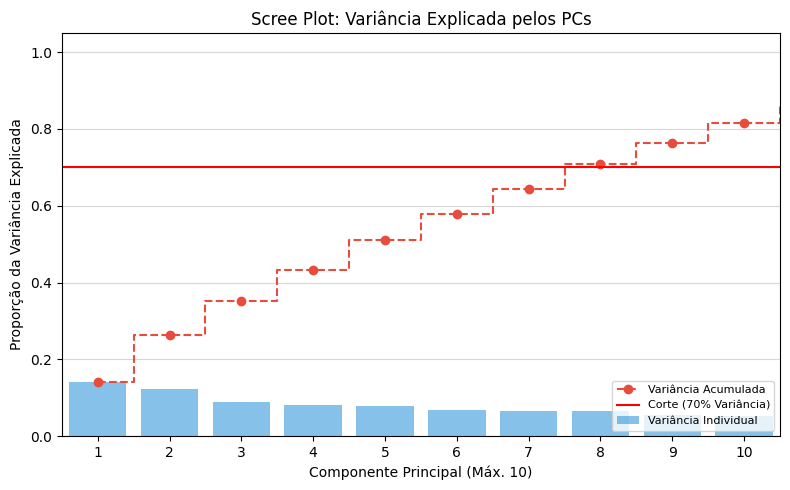

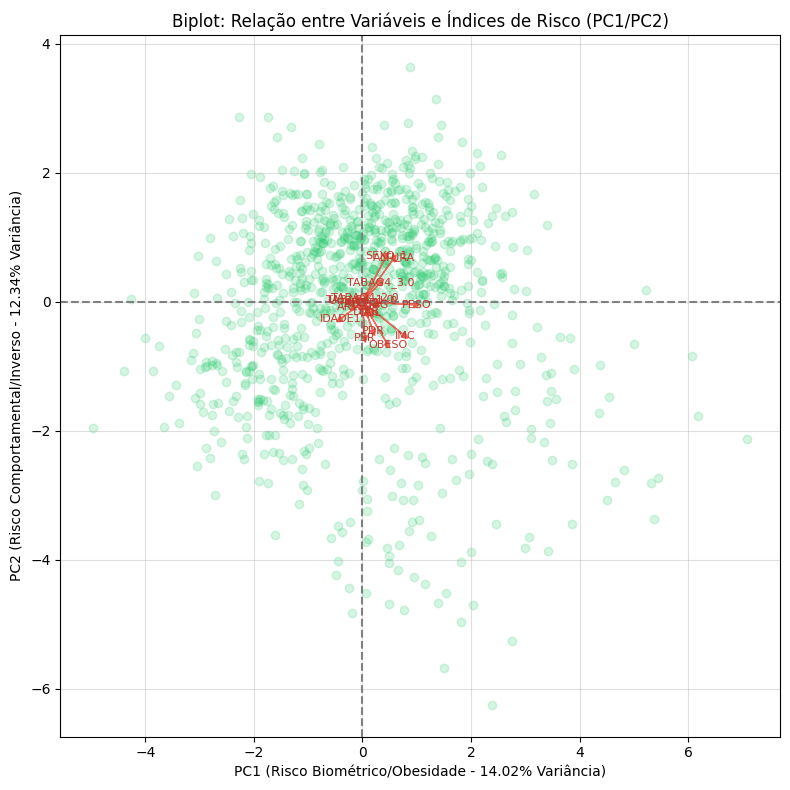


--- 5. Regressão Logística e Gráficos de Coeficientes ---

ANÁLISE DE REGRESSÃO LOGÍSTICA PARA O ALVO: INFARTO
AUC (Area Under the Curve) do Modelo: 0.5720
Coeficientes da Regressão (Importância Preditora dos Índices de Risco):
Risco_PC14    0.385258
Risco_PC2     0.221672
Risco_PC6     0.176116
Risco_PC15    0.122884
Risco_PC4     0.107837
Risco_PC9     0.099170
Risco_PC1     0.088066
Risco_PC16    0.067722
Risco_PC8     0.067495
Risco_PC5     0.022431
Risco_PC11    0.013056
Risco_PC3    -0.078307
Risco_PC13   -0.117509
Risco_PC12   -0.135055
Risco_PC7    -0.192295
Risco_PC10   -0.201785
Risco_PC17   -0.625721

ANÁLISE DE REGRESSÃO LOGÍSTICA PARA O ALVO: GLO
AUC (Area Under the Curve) do Modelo: 0.7031
Coeficientes da Regressão (Importância Preditora dos Índices de Risco):
Risco_PC14    0.520772
Risco_PC8     0.458074
Risco_PC11    0.384226
Risco_PC6     0.307785
Risco_PC16    0.279725
Risco_PC3     0.254398
Risco_PC9     0.215960
Risco_PC5     0.201967
Risco_PC13    0.124639
Risco_P

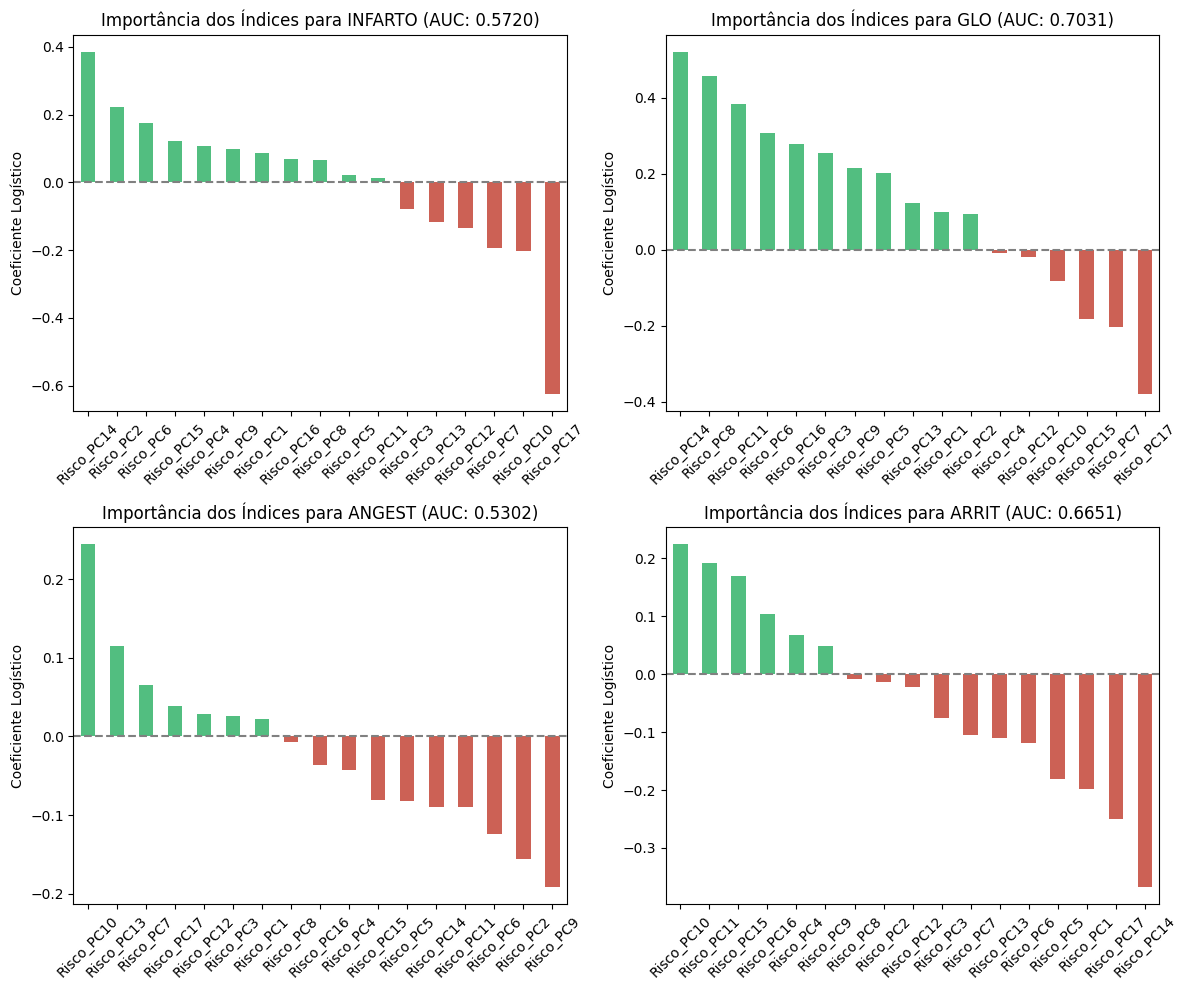

In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import warnings

# Ignorar FutureWarning do Scikit-learn para manter o output limpo
warnings.filterwarnings('ignore', category=FutureWarning)

# =========================================================
# --- 1. CONFIGURAÇÃO DE VARIÁVEIS (FÁCIL DE MUDAR) ---
# =========================================================

FILE_NAME = 'coronarias_drop.csv'
target_list = ['INFARTO', 'GLO', 'ANGEST', 'ARRIT']
colunas_categoricas_multi = ['SEXO', 'AH3', 'TABAG4']
N_COMPONENTES = 17  # <--- VARIÁVEL PRINCIPAL PARA AJUSTAR O NÚMERO DE PCs

# Carregamento do DataFrame - CORREÇÃO: Usando sep=';'
try:
    df = pd.read_csv(FILE_NAME, sep=';')
    print(f"Dados carregados com sucesso de {FILE_NAME}. Linhas: {len(df)}")
except FileNotFoundError:
    print(f"ERRO: Arquivo '{FILE_NAME}' não encontrado. Verifique o caminho.")
    exit()

# --- 2. PRÉ-PROCESSAMENTO: TRATAMENTO DE CATEGÓRICAS E LIMPEZA ---

colunas_categoricas_para_dummy = [col for col in colunas_categoricas_multi if col in df.columns]
df_final = pd.get_dummies(df, columns=colunas_categoricas_para_dummy, drop_first=True, prefix_sep='_')

colunas_excluir = target_list + colunas_categoricas_para_dummy
colunas_para_pca = [col for col in df_final.columns if col not in colunas_excluir]

# Remove NaN e prepara os dados para PCA
df_pca = df_final[colunas_para_pca].copy()
df_pca.dropna(inplace=True)
df_final = df_final.loc[df_pca.index] # Alinha df_final com df_pca

# Padronização (Escalonamento)
scaler = StandardScaler()
dados_escalados = scaler.fit_transform(df_pca)

# --- 3. APLICAÇÃO DA PCA (DINÂMICO) ---

# Roda a PCA com o número máximo de componentes (para o Scree Plot)
pca_completa = PCA() 
pca_completa.fit(dados_escalados)

# Aplica PCA para o número de componentes definido (N_COMPONENTES)
n_features = df_pca.shape[1]
n_pcs_ajustado = min(N_COMPONENTES, n_features) # Garante que N_COMPONENTES não exceda o número de features

pca_nd = PCA(n_components=n_pcs_ajustado) 
componentes = pca_nd.fit_transform(dados_escalados)

# Gera a tabela de Loadings para o número de componentes ajustado
loadings_df = pd.DataFrame(
    pca_nd.components_.T,
    columns=[f'PC{i+1}' for i in range(n_pcs_ajustado)],
    index=df_pca.columns
)

print(f"\n--- Loadings (Pesos) dos Componentes Principais (PC1 a PC{n_pcs_ajustado}) ---")
print("Interpretação: Os valores indicam a contribuição de cada variável para o PC (índice).")
print(loadings_df.to_string())


# --- 4. GERAÇÃO DOS GRÁFICOS DE PCA ---

print("\n--- Gerando Gráficos de Análise de Componentes Principais ---")

# 4.1. Scree Plot (Variância Explicada)
variancia_explicada = pca_completa.explained_variance_ratio_
variancia_acumulada = np.cumsum(variancia_explicada)
n_pc_scree = min(10, len(variancia_explicada)) # Limita o Scree Plot a 10 PCs ou ao total de features

plt.figure(figsize=(8, 5)) # Tamanho menor
plt.bar(range(1, len(variancia_explicada) + 1), variancia_explicada, alpha=0.6, color='#3498db', label='Variância Individual')
plt.step(range(1, len(variancia_acumulada) + 1), variancia_acumulada, where='mid', color='#e74c3c', linestyle='--', marker='o', label='Variância Acumulada')

plt.axhline(y=0.70, color='r', linestyle='-', label='Corte (70% Variância)') # Novo corte para interpretação

plt.title('Scree Plot: Variância Explicada pelos PCs', fontsize=12)
plt.xlabel(f'Componente Principal (Máx. {n_pc_scree})', fontsize=10)
plt.ylabel('Proporção da Variância Explicada', fontsize=10)
plt.xticks(np.arange(1, n_pc_scree + 1, 1)) # Limita o eixo X
plt.xlim(0.5, n_pc_scree + 0.5)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.show()


# 4.2. Biplot (PC1 vs PC2) - TAMANHO MENOR
# O Biplot sempre usa PC1 e PC2 (primeiros 2 componentes)
n_biplot = min(2, n_pcs_ajustado)
pca_biplot = PCA(n_components=n_biplot)
componentes_biplot = pca_biplot.fit_transform(dados_escalados)

if n_biplot >= 2:
    loadings_2d = pca_biplot.components_[:2].T * np.sqrt(pca_biplot.explained_variance_[:2])
    componentes_2d = componentes_biplot[:, :2]

    plt.figure(figsize=(8, 8)) # Tamanho menor

    # Plotar os scores das observações (pontos)
    plt.scatter(componentes_2d[:, 0], componentes_2d[:, 1], alpha=0.2, color='#2ecc71', label='Observações')

    # Plotar os loadings das variáveis (setas)
    for i, variable in enumerate(df_pca.columns):
        # Desenha a seta
        plt.arrow(0, 0, loadings_2d[i, 0], loadings_2d[i, 1], color='#e74c3c', alpha=0.8, head_width=0.1, head_length=0.1)
        # Adiciona o nome da variável
        plt.text(loadings_2d[i, 0] * 1.05, loadings_2d[i, 1] * 1.05, variable, color='#c0392b', fontsize=8, ha='center', va='center')

    pc1_variance = pca_biplot.explained_variance_ratio_[0] * 100
    pc2_variance = pca_biplot.explained_variance_ratio_[1] * 100

    plt.title('Biplot: Relação entre Variáveis e Índices de Risco (PC1/PC2)', fontsize=12)
    plt.xlabel(f'PC1 (Risco Biométrico/Obesidade - {pc1_variance:.2f}% Variância)', fontsize=10)
    plt.ylabel(f'PC2 (Risco Comportamental/Inverso - {pc2_variance:.2f}% Variância)', fontsize=10)
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    plt.grid(alpha=0.4)
    plt.tight_layout()
    plt.show()
else:
    print("\nAVISO: Não foi possível gerar o Biplot (PC1 vs PC2) pois N_COMPONENTES < 2.")


# --- 5. REGRESSÃO LOGÍSTICA E GRÁFICOS DE COEFICIENTES (DINÂMICO) ---

print("\n--- 5. Regressão Logística e Gráficos de Coeficientes ---")

pc_names = [f'Risco_PC{i+1}' for i in range(n_pcs_ajustado)]

# Adicione todos os PCs (1 a N_COMPONENTES) ao DataFrame de features
for i in range(n_pcs_ajustado):
    df_pca[pc_names[i]] = componentes[:, i]

X = df_pca[pc_names] # Define X para incluir todos os PCs

# Prepara a figura para os gráficos de coeficientes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, target in enumerate(target_list):
    if target not in df_final.columns or df_final[target].nunique() != 2:
        print(f"\nAVISO: A coluna alvo '{target}' não é binária ou não foi encontrada. Pulando.")
        axes[i].set_title(f"Alvo '{target}' (Dados Inválidos)", fontsize=12)
        continue

    y = df_final[target] 
    
    # Divida os dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Ajuste o Modelo
    modelo_logistico = LogisticRegression(solver='liblinear', random_state=42)
    modelo_logistico.fit(X_train, y_train)

    # Coeficientes
    coeficientes = pd.Series(modelo_logistico.coef_[0], index=pc_names).sort_values(ascending=False)
    
    # Avalie o Modelo (AUC)
    y_pred_proba = modelo_logistico.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)

    # Print dos resultados
    print(f"\n=======================================================")
    print(f"ANÁLISE DE REGRESSÃO LOGÍSTICA PARA O ALVO: {target}")
    print(f"=======================================================")
    print(f"AUC (Area Under the Curve) do Modelo: {auc:.4f}")
    print("Coeficientes da Regressão (Importância Preditora dos Índices de Risco):")
    print(coeficientes.to_string())

    # Plotagem no subplot correto
    ax = axes[i]
    colors = ['#27ae60' if c > 0 else '#c0392b' for c in coeficientes]
    
    coeficientes.plot(kind='bar', ax=ax, color=colors, alpha=0.8)
    ax.set_title(f'Importância dos Índices para {target} (AUC: {auc:.4f})', fontsize=12)
    ax.set_ylabel('Coeficiente Logístico', fontsize=10)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=45)
    ax.axhline(0, color='gray', linestyle='--')

plt.tight_layout()
plt.show()